In [1]:
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from timeit import Timer
from tqdm import tqdm
from pandas import DataFrame as df
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import uniform as rand
import scipy.io as sio
import scipy.stats
import scipy.ndimage as ndimage
from scipy.signal import savgol_filter
from scipy.signal.windows import tukey
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter
from skimage.transform import rescale, resize
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pp
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from numpy.matlib import repmat

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization, Activation, Add, Flatten, Reshape,
    SpatialDropout1D, GaussianDropout, Conv1D, Conv2D, Conv2DTranspose, ZeroPadding1D,
    MaxPooling1D, UpSampling1D, concatenate, GlobalAveragePooling1D
)

2025-07-13 07:00:36.429900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752390036.657932      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752390036.728648      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("1. Loading geoelectric data...")
df = pd.read_csv("/kaggle/input/geomodel/geoelectric_models.csv")

X_raw = df[[f'dBzdt_{i}' for i in range(1, 41)]].values
y_raw = df[[f'rho_{i}' for i in range(1, 41)]].values

X = np.log10(X_raw + 10)
y = np.log10(y_raw)

X_train, X_test_main, y_train, y_True_main = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_True = train_test_split(X_test_main, y_True_main, test_size=0.05, random_state=42)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_valid = scaler_X.transform(X_valid)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_valid = scaler_y.transform(y_valid)
y_test = scaler_y.transform(y_True)

X_train = X_train[..., np.newaxis]  
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

y_train = y_train[..., np.newaxis]  
y_valid = y_valid[..., np.newaxis]
y_test = y_test[..., np.newaxis]

print(f"Data shape: X={X.shape}, y={y.shape}")
print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Valid: X={X_valid.shape}, y={y_valid.shape}")
print(f"Test:  X={X_test.shape}, y={y_test.shape}")


1. Loading geoelectric data...
Data shape: X=(10000, 40), y=(10000, 40)
Train: X=(8000, 40, 1), y=(8000, 40, 1)
Valid: X=(1900, 40, 1), y=(1900, 40, 1)
Test:  X=(100, 40, 1), y=(100, 40, 1)


In [3]:
def GPRNet_modified(im_height=40, neurons=8, kern_sz=5, enable_dropout=False, dp_coeff=0.2):
    input_img = Input((im_height, 1))  # (40, 1)

    conv1 = Conv1D(neurons, kernel_size=kern_sz, activation='relu', padding='same')(input_img)  # (40, n)
    pool1 = MaxPooling1D(2, padding='same')(conv1)  # (20, n)

    conv2 = Conv1D(neurons*2, kernel_size=kern_sz, activation='relu', padding='same')(pool1)  # (20, 2n)
    pool2 = MaxPooling1D(2, padding='same')(conv2)  # (10, 2n)

    conv3 = Conv1D(neurons*4, kernel_size=kern_sz, activation='relu', padding='same')(pool2)  # (10, 4n)
    pool3 = MaxPooling1D(2, padding='same')(conv3)  # (5, 4n)

    py1 = Conv1D(neurons*8, kernel_size=kern_sz, dilation_rate=1, activation='relu', padding='same')(pool3)
    py2 = Conv1D(neurons*8, kernel_size=kern_sz, dilation_rate=2, activation='relu', padding='same')(pool3)
    py3 = Conv1D(neurons*8, kernel_size=kern_sz, dilation_rate=4, activation='relu', padding='same')(pool3)
    merge1 = concatenate([py1, py2, py3, pool3])  # (5, ...)

    mgconv = Conv1D(neurons*8, kernel_size=3, activation='relu', padding='same')(merge1)
    upmgconv = UpSampling1D(size=8)(mgconv)  # (5 → 40)

    deconv1 = Conv1D(neurons*4, kernel_size=kern_sz, activation='relu', padding='same')(pool3)  # (5, 4n)
    up1 = UpSampling1D(2)(deconv1)  # 5 → 10

    deconv2 = Conv1D(neurons*2, kernel_size=kern_sz, activation='relu', padding='same')(up1)  # (10, 2n)
    up2 = UpSampling1D(2)(deconv2)  # 10 → 20

    deconv3 = Conv1D(neurons, kernel_size=kern_sz, activation='relu', padding='same')(up2)  # (20, n)
    up3 = UpSampling1D(2)(deconv3)  # 20 → 40

    merge2 = concatenate([upmgconv, up3])  # (40, ...)

    deconv4 = Conv1D(neurons, kernel_size=kern_sz, activation='relu', padding='same')(merge2)

    output = Conv1D(1, kernel_size=1, activation='linear')(deconv4)  # (40, 1)

    model = Model(inputs=input_img, outputs=output)
    return model

Epoch 1: Train MSE=0.567344, Test MSE=0.404225, Train R²=0.520768, Test R²=0.456340
Epoch 10: Train MSE=0.179021, Test MSE=0.163770, Train R²=0.832029, Test R²=0.779739
Epoch 20: Train MSE=0.145874, Test MSE=0.137536, Train R²=0.837312, Test R²=0.815022
Epoch 30: Train MSE=0.132144, Test MSE=0.116018, Train R²=0.884933, Test R²=0.843963
Epoch 50: Train MSE=0.106444, Test MSE=0.101199, Train R²=0.887474, Test R²=0.863894
Epoch 60: Train MSE=0.097346, Test MSE=0.100115, Train R²=0.898759, Test R²=0.865352
Epoch 70: Train MSE=0.093429, Test MSE=0.081901, Train R²=0.917909, Test R²=0.889848
Epoch 80: Train MSE=0.084724, Test MSE=0.082458, Train R²=0.912216, Test R²=0.889098
Epoch 90: Train MSE=0.082541, Test MSE=0.081879, Train R²=0.924906, Test R²=0.889877
Epoch 100: Train MSE=0.076306, Test MSE=0.075417, Train R²=0.923285, Test R²=0.898568
Epoch 110: Train MSE=0.065243, Test MSE=0.083949, Train R²=0.936585, Test R²=0.887093
Epoch 120: Train MSE=0.068919, Test MSE=0.065002, Train R²=0.937

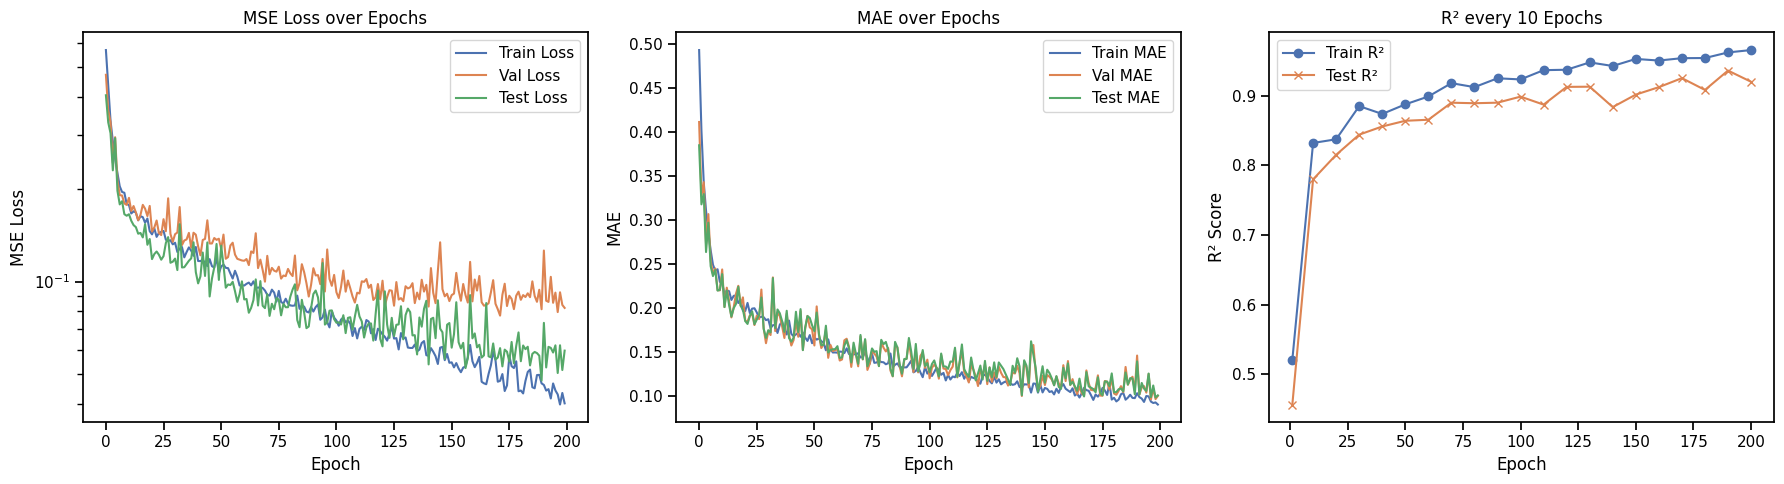

Saved training history and parameters to training_history.csv


In [9]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

EPOCHS        = 200
BATCH_SIZE    = 32
LEARNING_RATE = 5e-4
IM_HEIGHT     = 40
NEURONS       = 16
KERN_SZ       = 5
ENABLE_DROPOUT= True
DP_COEFF      = 0.2

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = GPRNet_modified(
        im_height=IM_HEIGHT,
        neurons=NEURONS,
        kern_sz=KERN_SZ,
        enable_dropout=ENABLE_DROPOUT,
        dp_coeff=DP_COEFF
    )
    model.compile(optimizer=Adam(LEARNING_RATE), loss='mse', metrics=['mae'])

history = {
    'train_loss': [], 'val_loss': [], 'test_loss': [],
    'train_mae':  [], 'val_mae':  [], 'test_mae':  [],
    'train_r2':   [], 'sampled_test_r2': []
}

with tf.device('/GPU:0'):
    for epoch in range(1, EPOCHS + 1):
        hist = model.fit(
            X_train, y_train,
            validation_data=(X_valid, y_valid),
            batch_size=BATCH_SIZE,
            epochs=1,
            verbose=0,
            callbacks=[reduce_lr, early_stopping]
        )
        history['train_loss'].append(hist.history['loss'][0])
        history['val_loss'].append(hist.history['val_loss'][0])
        history['train_mae'].append(hist.history['mae'][0])
        history['val_mae'].append(hist.history['val_mae'][0])

        ypred = model.predict(X_test, verbose=0)
        history['test_loss'].append(mean_squared_error(y_test.flatten(), ypred.flatten()))
        history['test_mae'].append(mean_absolute_error(y_test.flatten(), ypred.flatten()))

        if epoch % 10 == 0 or epoch == 1:
            y_train_pred = model.predict(X_train, verbose=0)
            history['train_r2'].append(r2_score(y_train.flatten(), y_train_pred.flatten()))
            history['sampled_test_r2'].append(r2_score(y_test.flatten(), ypred.flatten()))
            print(
                f"Epoch {epoch}: "
                f"Train MSE={history['train_loss'][-1]:.6f}, "
                f"Test MSE={history['test_loss'][-1]:.6f}, "
                f"Train R²={history['train_r2'][-1]:.6f}, "
                f"Test R²={history['sampled_test_r2'][-1]:.6f}"
            )

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'],   label='Val Loss')
plt.plot(history['test_loss'],  label='Test Loss')
plt.title('MSE Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['train_mae'], label='Train MAE')
plt.plot(history['val_mae'],   label='Val MAE')
plt.plot(history['test_mae'],  label='Test MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)
r2_epochs = [1] + list(range(10, EPOCHS + 1, 10))
plt.plot(r2_epochs, history['train_r2'], marker='o', label='Train R²')
plt.plot(r2_epochs, history['sampled_test_r2'], marker='x', label='Test R²')
plt.title('R² every 10 Epochs')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.legend()

plt.tight_layout()
plt.show()

params = {
    'im_height': IM_HEIGHT,
    'neurons': NEURONS,
    'kern_sz': KERN_SZ,
    'enable_dropout': ENABLE_DROPOUT,
    'dp_coeff': DP_COEFF,
    'batch_size': BATCH_SIZE,
    'epochs': EPOCHS,
    'learning_rate': LEARNING_RATE
}

df = pd.DataFrame({
    **{k: [v]*len(history['train_loss']) for k, v in params.items()},
    'epoch':      list(range(1, len(history['train_loss']) + 1)),
    'train_loss': history['train_loss'],
    'val_loss':   history['val_loss'],
    'test_loss':  history['test_loss'],
    'train_mae':  history['train_mae'],
    'val_mae':    history['val_mae'],
    'test_mae':   history['test_mae']
})

df['train_r2'] = pd.NA
df['test_r2']  = pd.NA
for idx, ep in enumerate(r2_epochs):
    df.at[ep - 1, 'train_r2'] = history['train_r2'][idx]
    df.at[ep - 1, 'test_r2']  = history['sampled_test_r2'][idx]

csv_path = 'training_history.csv'
df.to_csv(csv_path, index=False)
print(f"Saved training history and parameters to {csv_path}")

/tmp/ipykernel_36/123368626.py:39: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


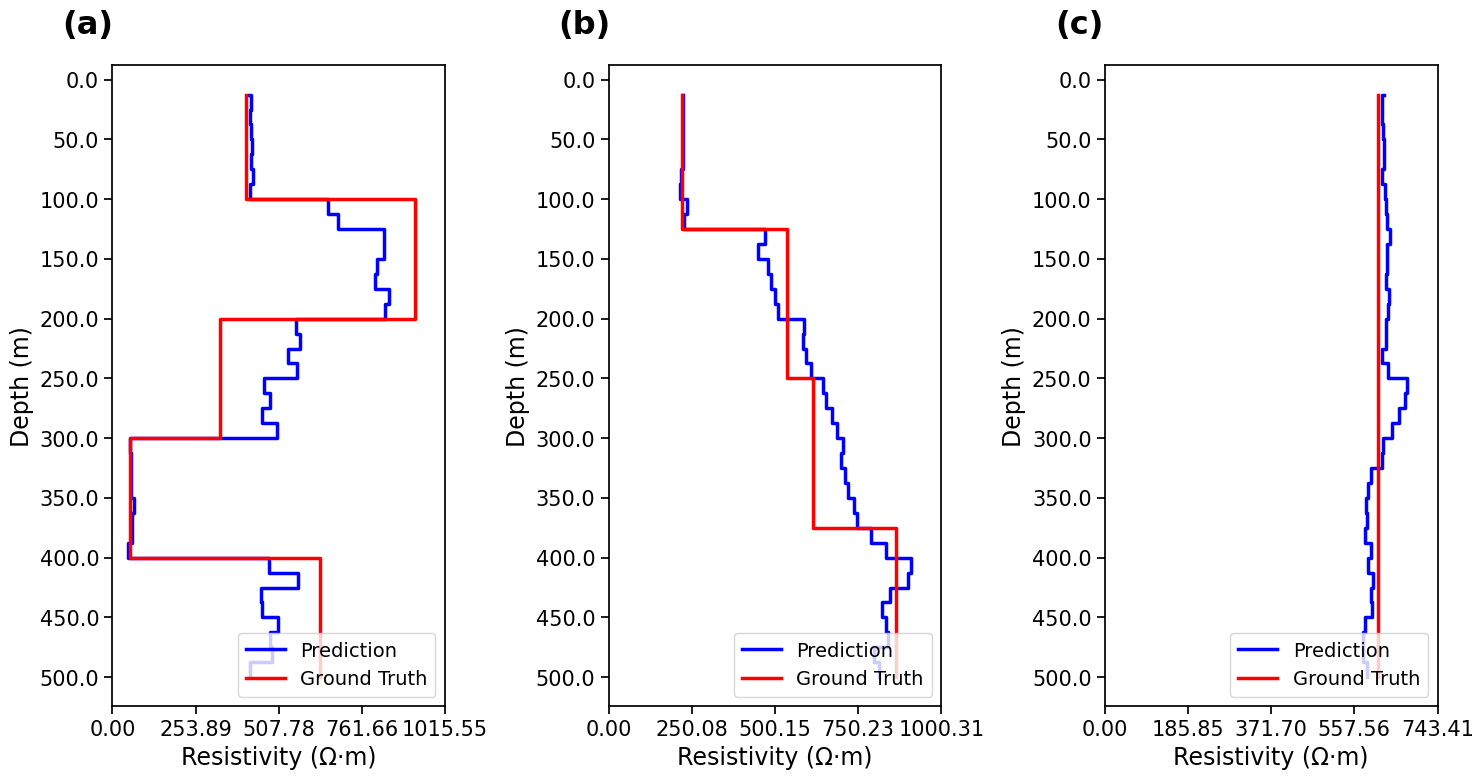

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from matplotlib.ticker import FormatStrFormatter

def figure4(ypred_scaled, y_true_scaled, scaler_y):
    ypred = np.power(10, scaler_y.inverse_transform(ypred_scaled.squeeze()))
    y_true = np.power(10, scaler_y.inverse_transform(y_true_scaled.squeeze()))

    fig, axs = plt.subplots(1, 3, figsize=(15, 8))
    fig.tight_layout()
    sns.set_theme(style=None)

    for i in range(3):
        ind = np.random.randint(0, len(ypred))
        ax = axs[i]
        ax.invert_yaxis()

        depth = np.arange(1, 41) * 12.5  

        ax.step(ypred[ind], depth, where='post', label='Prediction', color='blue', linewidth=2.5)
        ax.step(y_true[ind], depth, where='post', label='Ground Truth', color='red', linewidth=2.5)

        ax.set_xlabel('Resistivity (Ω·m)', fontsize=17)
        ax.set_ylabel('Depth (m)', fontsize=17)

        x_max = max(np.max(y_true[ind]), np.max(ypred[ind])) * 1.1
        ax.set_xticks(np.linspace(0, x_max, 5))
        ax.set_xticklabels(np.round(np.linspace(0, x_max, 5), 2), fontsize=15)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        ax.set_yticks(np.linspace(0, 500, 11))
        ax.set_yticklabels(np.round(np.linspace(0, 500, 11)), fontsize=15)

        ax.legend(loc='lower right', fontsize=14)
        ax.text(-0.15, 1.05, f'({string.ascii_lowercase[i]})', transform=ax.transAxes, size=23, weight='bold')

    fig.tight_layout()
    plt.show()
figure4(ypred, y_test, scaler_y)


In [17]:
model.save('best_model_32_0.2.h5')
print("Saving Model....")
print("Done..")

Saving Model....
Done..


In [18]:
import pandas as pd
y_pred = model.predict(X_test, verbose=0)
y_true_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

print("\nFirst 10 samples: Actual vs. Predicted")
for i in range(10):
    print(f"Sample {i+1:2d}: Actual = {y_true_flat[i]:.6f}, Predicted = {y_pred_flat[i]:.6f}")

df_results = pd.DataFrame({
    'Actual':   y_true_flat,
    'Predicted': y_pred_flat
})
print("\nHead of full results:")
print(df_results.head(10))



First 10 samples: Actual vs. Predicted
Sample  1: Actual = 0.556147, Predicted = 0.554077
Sample  2: Actual = 0.556147, Predicted = 0.549718
Sample  3: Actual = 0.556147, Predicted = 0.569783
Sample  4: Actual = 0.556147, Predicted = 0.573694
Sample  5: Actual = 0.556147, Predicted = 0.574872
Sample  6: Actual = 0.556147, Predicted = 0.572126
Sample  7: Actual = 0.556147, Predicted = 0.564620
Sample  8: Actual = 0.556147, Predicted = 0.560826
Sample  9: Actual = 0.553104, Predicted = 0.600721
Sample 10: Actual = 0.553104, Predicted = 0.607611

Head of full results:
     Actual  Predicted
0  0.556147   0.554077
1  0.556147   0.549718
2  0.556147   0.569783
3  0.556147   0.573694
4  0.556147   0.574872
5  0.556147   0.572126
6  0.556147   0.564620
7  0.556147   0.560826
8  0.553104   0.600721
9  0.553104   0.607611
